**NOTE**: Please make a personal copy of this notebook by selecting 'File' > 'Save a copy in Drive' in the menu bars above.

If you are used to the shortcut Shift + Tab to see documentation then you should go to 'Tools' > 'Settings' > 'Editor' and uncheck the option 'Automatically trigger code completions'


In this lab we will start with some basics about Python and describe the machine learning framework that we will use extensively throughout the NYU AI School. We will highlight the details of this framework viz. the modules of interest to us and try to give you a realistic view of how to build a machine learning classifier in production. We will treat our machine learning model as a 'black box' as a lot of people often do in industry, much to their detriment, and demonstrate that even without knowing what machine learning is doing, we can generate good predictions for images. In future lectures it will become clearer what this model is doing, and we will introduce more layers and techniques to build faster, bigger, and better models! 

By the end of this lab you should be able to:

* Load, manipulate, and utilise an image dataset for machine learning
* Use a convolutional neural network for image classification



## Representing an Image as a Matrix of Integers

An image can be represented numerically by taking the numeric values of pixels representing the intensity of a particular primary color channel (eg. R, G, B). In grayscale images, there is only one channel. [Brandon Rohrer's post](https://www.kdnuggets.com/2020/01/convert-picture-numbers.html) has a nice visualization of this shown below.


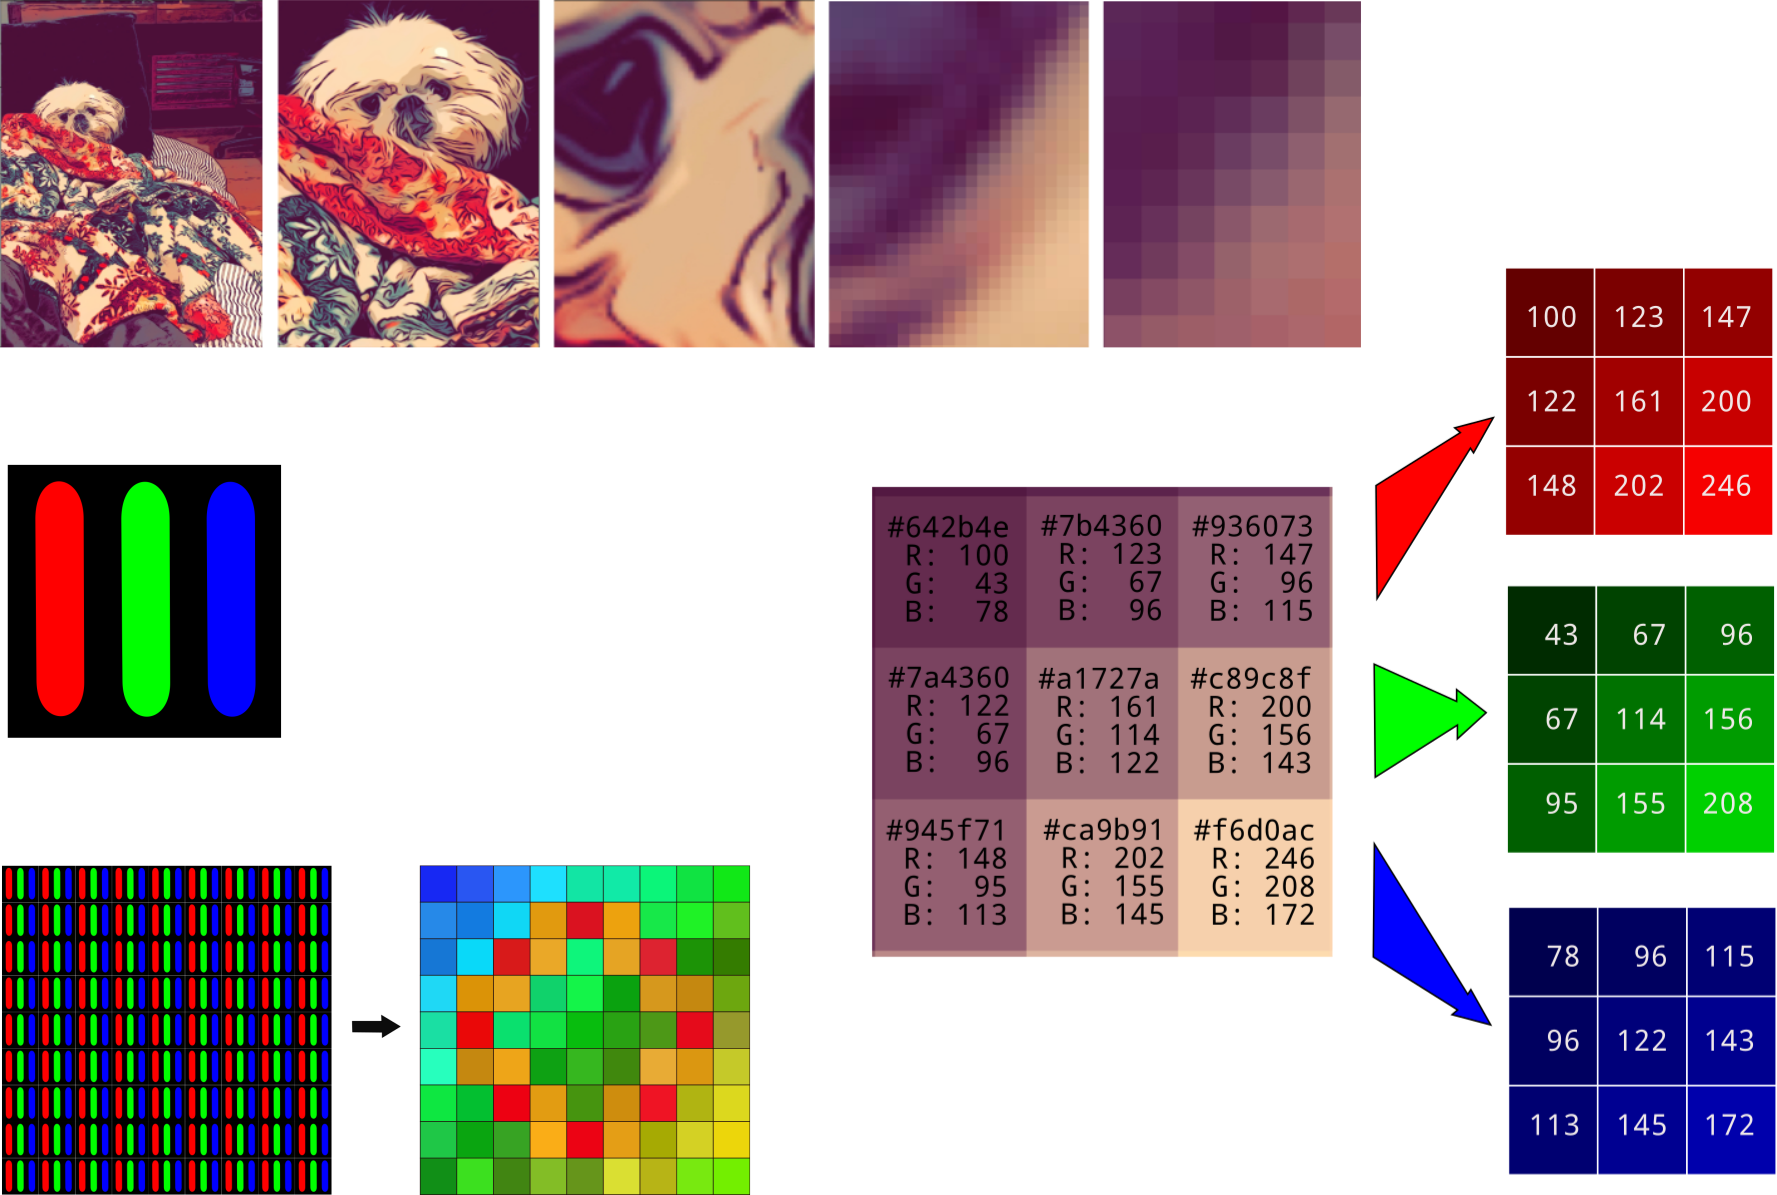

First let's install the three python libraries we will require: ``matplotlib``, ``torch``, and ``numpy`` using the pip package manager

In [ ]:
!pip install matplotlib torch numpy

In [ ]:
%matplotlib inline
# make all plots inline in the notebook


Example: Training a Classifier
=====================

There are three main tasks you will complete for this tutorial:
1. Define neural networks;
2. Compute loss;
3. Compute updates to the weights of the network.

For this tutorial, we will use the CIFAR10 dataset and the MNIST dataset.

- MNIST has images of 10 classes of digits from 0 - 9.
- CIFAR 10 has the classes: ‘airplane’, ‘automobile’, ‘bird’, ‘cat’, ‘deer’,
‘dog’, ‘frog’, ‘horse’, ‘ship’, ‘truck’. The images in CIFAR-10 are of
size 3x32x32, i.e. 3-channel color images of 32x32 pixels in size.


Training an image classifier
----------------------------

1. Loading and normalizing CIFAR10

Using the ``torchvision`` module from the ``torch`` package, it’s extremely easy to load CIFAR10.



In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms

1. Load and normalize the CIFAR10 training and test datasets using

The output of torchvision datasets are PILImage images of range [0, 1].
We transform them to Tensors of normalized range [-1, 1].

In [ ]:
transform = transforms.Compose(                                 # chain two transforms together sequentially using transforms.Compose
    [transforms.ToTensor(),                                     # the first transform converts the input to a tensor
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])   # the second normalizes the transformed images

# first define the train dataset by using the inbuilt CIFAR 10 data
# use the inbuilt CIFAR 10 dataset and load it into a trainloader instance
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

# create the test dataset and load it into a testloader
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

# define the 10 classes of images that we are interested in identifying
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


Let us show some of the training images, for fun.



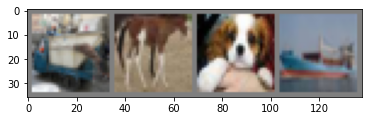

truck horse   dog  ship


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# here's a function to plot an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize the normalized data
    npimg = img.numpy()     # 
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
# use an iterator over the trainloader to retrieve an image
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
# use the imshow function and torchvision.utils.make_grid to produce a grid of images
imshow(torchvision.utils.make_grid(images))

# print labels for all of the images underneath the grid of images
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

## Convolutions and Filters

Given any matrix of numbers that represents the input image, we want to find patterns in the matrix that allow us to identify the objects present in the image. One way of doing that is to convolve an image with a filter (or kernel) designed to reveal information present in the image. So the filter serves as a 'feature detector'. Here's an example from [this nicely illustrated post by Akshaj Verma](https://towardsdatascience.com/pytorch-basics-how-to-train-your-neural-net-intro-to-cnn-26a14c2ea29). Note that while this is a 2-dimensional convolution, we can similarly create single or higher-dimensional convolutions.

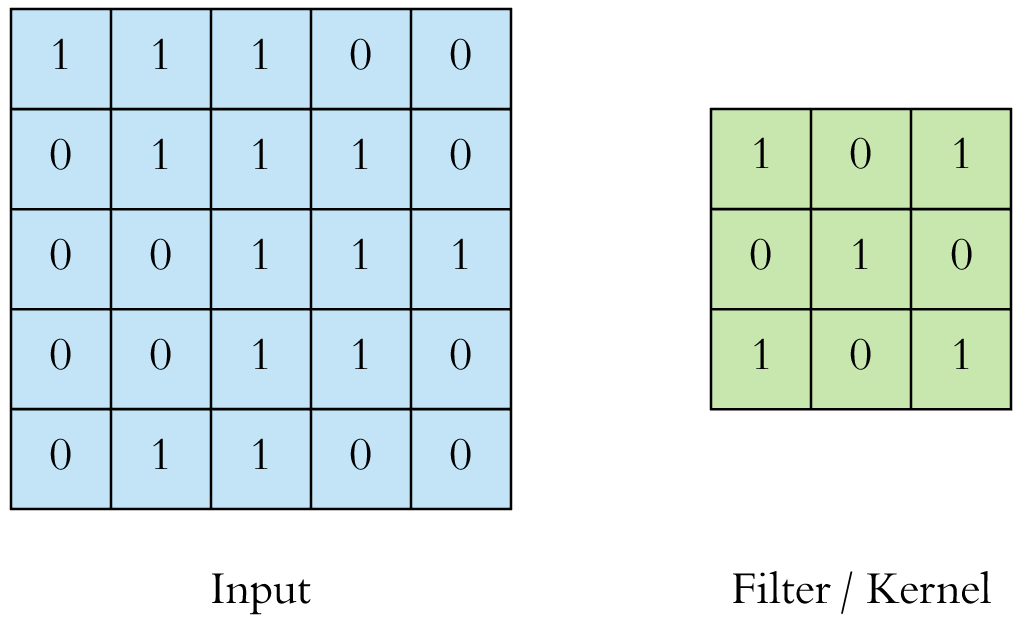

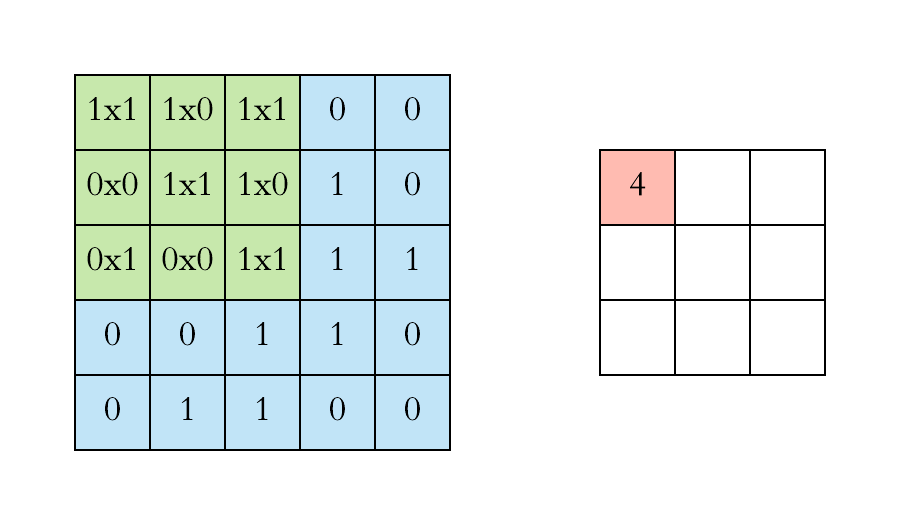

### 1. Write Convolution code
Let's try writing our own code to define a convolution. Start with the two matrices given below and write your convolve function using pytorch 

In [ ]:
import torch.nn.functional as F

n_channels = 1    # we consider a single channel only

sample_img = torch.Tensor(([
                             [1, 1, 1, 0, 0],
                             [0, 1, 1, 1, 0],
                             [0, 0, 1, 1, 1],
                             [0, 0, 1, 1, 0],
                             [0, 1, 1, 0, 0]
]))
sample_img = sample_img.view(1, 1, 5, 5)            # convert it to batch_size * n_channels * (image dimensions)

sample_kernel = torch.Tensor(([
                             [1, 0, 1],
                             [0, 1, 0],
                             [1, 0, 1]
]))
sample_kernel = sample_kernel.view(1, 1, 3, 3)      # convert it to batch_size * n_channels * (kernel dimensions)

convolved_output = F.conv2d(sample_img, sample_kernel, padding=0, stride=1)

In [ ]:
convolved_output

tensor([[[[4., 3., 4.],
          [2., 4., 3.],
          [2., 3., 4.]]]])

### 2. Define a Convolutional Neural Network

We can place multiple layers of convolutions on top of each otner (also called 'stacking layers') to create a 'deep' convolutional neural network. We need the neural network to take an input of 3-channel images so our ``in_channels`` for the first convolutional layer must be 3.



In [ ]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)         # arguments are in_channels, out_channels, kernel_size
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)        # calculate the in_channels based on the out_channels from the conv1 layer
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)           # calculate the arguments to the fc2 layer by looking at the line above and line below
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))    # combine a convolution, relu, and max pooling in a single line
        x = self.pool(F.relu(self.conv2(x)))    # again, combine a convolution, relu, and max pooling in a single line
        x = x.view(-1, 16 * 5 * 5)              # reshape the output as required
        x = F.relu(self.fc1(x))                 # place a relu on top of the fc1 layer
        x = F.relu(self.fc2(x))                 # place a relu on top of the fc2 layer
        x = self.fc3(x)                         # pass through the final fully connected layer fc3
        return x


net = Net()                                     # instantiate your neural network

### 3. Define a Loss function and optimizer

Let's use a Classification Cross-Entropy loss and Stochastic Gradient Descent.



In [ ]:
import torch.optim as optim    # import the optim class from the torch.optim module

# define the criterion to be the CrossEntropyLoss class from the nn module
criterion = nn.CrossEntropyLoss()

# within torch.optim, for your SGD optimizer set the learning rate to 1e-3 and the momentum parameter to 0.9
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

### 4. Train the network

This is when things start to get interesting.
We simply have to loop over our data iterator, and feed the inputs to the
network and optimize.



In [ ]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)                         # first pass your inputs through your neural network instance to obtain outputs
        loss = criterion(outputs, labels)             # next, calculate the loss based on how well the outputs match the true labels
        loss.backward()                               # next, backpropagate the loss through the neural network for calculating the gradient of the parameters
        optimizer.step()                              # finally, use the calculated gradient for updating the parameter values 

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.216
[1,  4000] loss: 1.913
[1,  6000] loss: 1.700
[1,  8000] loss: 1.594
[1, 10000] loss: 1.501
[1, 12000] loss: 1.462
[2,  2000] loss: 1.401
[2,  4000] loss: 1.348
[2,  6000] loss: 1.307
[2,  8000] loss: 1.289
[2, 10000] loss: 1.270
[2, 12000] loss: 1.229
Finished Training


### 5. Test the network on the test data

We have trained the network for 2 passes over the training dataset.
But we need to check if the network has learnt anything at all.

We will check this by predicting the class label that the neural network
outputs, and checking it against the ground-truth. If the prediction is
correct, we add the sample to the list of correct predictions.

Okay, first step. Let us display an image from the test set to get familiar.



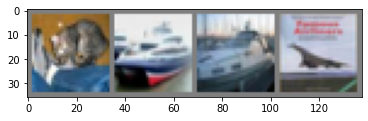

GroundTruth:    cat  ship  ship plane


In [ ]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

Okay, now let us see what the neural network thinks these examples above are:



In [ ]:
outputs = net(images)

The outputs are energies for the 10 classes.
The higher the energy for a class, the more the network
thinks that the image is of the particular class.
So, let's get the index of the highest energy:



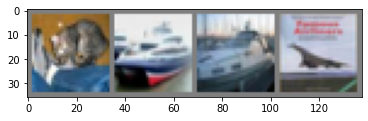

Predicted:    cat  ship  ship  ship


In [ ]:
_, predicted = torch.max(outputs, 1) 

imshow(torchvision.utils.make_grid(images))
print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

The results seem pretty good (if not, you might want to train your model for a larger number of epochs).

Let us look at how the network performs on the whole dataset.



In [ ]:
correct = 0
total = 0
with torch.no_grad():                              # we don't want to calculate gradient updates when using the test data!
    for data in testloader:                        # recall that a dataloader is essentially a list of (image, label) tuples 
        images, labels = data
        outputs = net(images)                      # pass the test image through the network to obtain outputs
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 57 %


That looks way better than chance, which is 10% accuracy (randomly picking
a class out of 10 classes).
Seems like the network learnt something.

Hmmm, what are the classes that performed well, and the classes that did
not perform well:



In [ ]:
class_correct = list(0. for i in range(10))        # create a list of 0's since you don't have any correct predictions yet
class_total = list(0. for i in range(10))
with torch.no_grad():

    for data in testloader:                        # iterate over your test loader
        images, labels = data
        outputs = net(images)

        # get the index of the maximum of the predictions for all classes 
        # and consider that as the predicted label
        # the second argument to torch.max() refers to the axis along which to calculate the max
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()        # check if your predictions match your labels
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()    # add the correct label at the right index
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))     # print the percentage accuracy 

Accuracy of plane : 60 %
Accuracy of   car : 65 %
Accuracy of  bird : 55 %
Accuracy of   cat : 33 %
Accuracy of  deer : 42 %
Accuracy of   dog : 47 %
Accuracy of  frog : 67 %
Accuracy of horse : 48 %
Accuracy of  ship : 78 %
Accuracy of truck : 58 %



How do we run these neural networks on the GPU?
```
  # use the GPU when we have larger models to train (remember to first change Colab Runtime > Change Runtime type > GPU)
  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
  net.to(device)
```

## Visualizing Filters and Features

"Filters"

By visualizing the filters of the trained model, we can understand how CNN learns the complex Spatial and Temporal pixel dependencies present in the image.

When Deep Learning folks talk about “filters” what they’re referring to is the learned weights of the convolutions. 

By visualising the learned weights we can get some idea as to how well our network has learned. For example, if we see a lot of zeros then we’ll know we have many dead filters that aren’t going much for our network — a great opportunity to do some pruning for model compression.


Take a look at the code below for visualising the filters and then scroll down for an explanation of how it works.

Code from [HERE](https://towardsdatascience.com/visualizing-convolution-neural-networks-using-pytorch-3dfa8443e74e)

In [ ]:
def plot_weights(model, layer, single_channel = True):
    #getting the weight tensor data
    if layer == 'conv1':
        weight_tensor = model.conv1.weight.data
        ncols = 6
    elif layer == 'conv2':
        weight_tensor = model.conv2.weight.data
        ncols = 12
  
    t = weight_tensor

    #kernels depth * number of kernels
    nplots = t.shape[0]*t.shape[1]
    
    nrows = 1 + nplots//ncols
    #convert tensor to numpy image
    npimg = np.array(t.numpy(), np.float32)
    
    count = 0
    fig = plt.figure(figsize=(ncols, nrows))
    
    #looping through all the kernels in each channel
    for i in range(t.shape[0]):
        for j in range(t.shape[1]):
            count += 1
            ax1 = fig.add_subplot(nrows, ncols, count)
            npimg = np.array(t[i, j].numpy(), np.float32)
            npimg = (npimg - np.mean(npimg)) / np.std(npimg)
            npimg = np.minimum(1, np.maximum(0, (npimg + 0.5)))
            ax1.imshow(npimg)
            ax1.set_title(str(i) + ',' + str(j))
            ax1.axis('off')
            ax1.set_xticklabels([])
            ax1.set_yticklabels([])
   
    plt.tight_layout()
    plt.show()


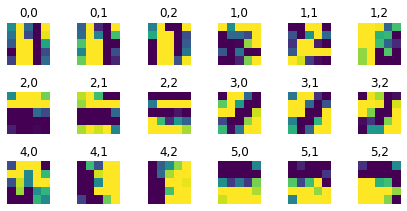

In [ ]:
plot_weights(net, 'conv1', single_channel = True)


**Self-learning:** Try increasing the width of your network (argument 2 of
the first ``nn.Conv2d``, and argument 1 of the second ``nn.Conv2d`` –
they need to be the same number), see what kind of speedup you get.

**Goals achieved**:

- Data manipulation in Pytorch using torchvision datasets and DataLoaders
- Train a small convolutional neural network to classify images


Heavily based on the original [Pytorch CNN Tutorial](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html)

# Class Assignment

Having seen how we can build a CIFAR 10 classifier, we will write our own MNIST classifier that will identify which digit is present in a grayscale image. Note that the image will now have only one channel unlike CIFAR 10 that needed 3 channels. This means you will need to modify the CNN to accept these images as inputs.



1. Load and normalize the training data for MNIST

In [ ]:
# since the data distribution changes from CIFAR10 to MNIST, you can use the normalization 
#         transforms.Normalize((0.1307,), (0.3081,))
# as an exercise you might like to calculate it by yourself
transform_MNIST=transforms.Compose([
        # first convert it to a tensor
        # then normalize the image
        ])

# define train and test datasets and their corresponding dataloaders
trainset_MNIST = torchvision.datasets.MNIST('mnist_data', train=??, download=True,
                    transform=??)
trainloader_MNIST = torch.utils.data.DataLoader(??, batch_size=4,
                                          shuffle=True, num_workers=2)

testset_MNIST = ??
testloader_MNIST = ??

# define the mnist classes
classes_MNIST = (??)

Visualize some of the training data

In [ ]:
# iterate over training data
dataiter = iter(??)
images, labels = dataiter.next()

# use imshow along with make_grid that was defined earlier
imshow(torchvision.utils.make_grid(??))

# print labels
print(' '.join('%5s' % classes_MNIST[labels[j]] for j in range(4)))

2. Define the Convolutional Neural Network arguments based on its given structure. Recall that the images are single-channel in this case.

In [ ]:
# understanding dimensions in convolutional neural networks
# also refer to this for visuals: https://towardsdatascience.com/the-most-intuitive-and-easiest-guide-for-convolutional-neural-network-3607be47480
print("initial image: ", images.shape)
conv1 = nn.Conv2d(1, 16, 3)
pool = nn.MaxPool2d(2, 2)
conv2 = nn.Conv2d(16, 32, 3)       

x = conv1(images)
print("after the 1st conv: (28 - 3 + 1) = ", x.shape)
x = pool(x)    
print("after the 1st pool: 26 // 2 = ", x.shape)
x = conv2(x)
print("after the 2nd conv: (28 - 3 + 1) = ", x.shape)
x = pool(x)    
print("after the 2nd pool: 11 // 2 = ", x.shape)

initial image:  torch.Size([4, 1, 28, 28])
after the 1st conv: (28 - 3 + 1) =  torch.Size([4, 16, 26, 26])
after the 1st pool: 26 // 2 =  torch.Size([4, 16, 13, 13])
after the 2nd conv: (28 - 3 + 1) =  torch.Size([4, 32, 11, 11])
after the 2nd pool: 11 // 2 =  torch.Size([4, 32, 5, 5])


In [ ]:
class CNN(nn.Module):
  def __init__(self):
    super(CNN, self).__init__()
    self.conv1 = nn.Conv2d(1, 16, 3)        # arguments are in_channels, out_channels, kernel_size
    self.pool = nn.MaxPool2d(2, 2)
    self.conv2 = nn.Conv2d(??, 32, 3)       # calculate the in_channels based on the out_channels from the conv1 layer
    self.fc1 = nn.Linear(32 * 5 * 5, 120)   # this is the most crucial calculation to understand the cnn
    self.fc2 = nn.Linear(??, 10)           # calculate the arguments to the fc2 layer by looking at the line above and line below

  def forward(self, x):
    x = self.pool(F.relu(self.conv1(x)))    # combine a convolution, relu, and max pooling in a single line
    x = self.pool(F.relu(self.conv2(x)))    # again, combine a convolution, relu, and max pooling in a single line
    x = x.view(-1, ??)                      # reshape the output as required by fc1
    x = F.relu(self.fc1(x))                 # place a relu on top of the fc1 layer
    x = self.fc2(x)                         # pass through the final fully connected layer fc2
    return x
    x = self.fc3(x)                         

# instantiate the neural network
net_MNIST = CNN()

In [ ]:
# define the criterion to be the CrossEntropyLoss class from the nn module
criterion = ??

# within torch.optim, for your SGD optimizer set the learning rate to 1e-3 and the momentum parameter to 0.9
optimizer = ??

In [ ]:
for epoch in range(1):  # loop over the dataset multiple times

    running_loss = ??  # initiate loss
    for i, data in enumerate(trainloader_MNIST, 0):
        # get the inputs and labels from data; data is a list of (input, label) tuples
        ??

        # zero the parameter gradients
        ??

        # forward + backward + optimize
        outputs = ??                                  # first pass your inputs through your neural network instance to obtain outputs
        loss = ??                                     # next, calculate the loss based on how well the outputs match the true labels
        ??                                            # next, backpropagate the loss through the neural network for calculating the gradient of the parameters
        optimizer.step()                              # finally, use the calculated gradient for updating the parameter values 

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

In [ ]:
class_correct = list(0. for i in range(10))        # create a list of 0's since you don't have any correct predictions yet
class_total = list(0. for i in range(10))
with torch.no_grad():

    for data in testloader_MNIST:                        # iterate over your test loader
        images, labels = ??
        outputs = ??

        # get the index of the maximum of the predictions for all classes 
        # and consider that as the predicted label
        # the second argument to torch.max() refers to the axis along which to calculate the max
        _, predicted = torch.max(outputs, 1)
        c = (?? == labels).squeeze()               # check if your predictions match your labels
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()    # add the correct label at the right index
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes_MNIST[i], 100 * class_correct[i] / class_total[i]))     # print the percentage accuracy 

Those are some really nice results! Can you visualize what's happening? (left to students).

**Hint:** Are the filters learning anything meaningful? What's an easy way to tell that they're not all zeros? (``plot_weights``)